In [9]:
require(tidyverse)
# install.packages('hoopR')
require(hoopR)
require(lubridate)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Loading required package: lubridate


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




In [10]:
years.vec = (2003:2022) %>% setdiff(., 2020)
start.dates.vec = as.Date(c('2003-03-18','2004-03-16', '2005-03-15', '2006-03-14', '2007-03-13', '2008-03-18', '2009-03-17', '2010-03-16', '2011-03-15', '2012-03-13', '2013-03-19', '2014-03-18', '2015-03-17', '2016-03-15', '2017-03-14', '2018-03-13', '2019-03-19', '2021-03-18', '2022-03-13'))

rip.df = data.frame(years.vec, start.dates.vec)

for (what.year in years.vec){

date.str = rip.df %>% filter(years.vec == what.year) %>% pull(start.dates.vec) %>% as.Date()

####

box.23 = hoopR::load_mbb_player_box(what.year) %>% mutate(pts = as.numeric(pts))

sched.23 = hoopR::load_mbb_schedule(what.year) %>% select(season, date, home_short_display_name, away_short_display_name, home_score, away_score, home_winner, home_logo, away_logo) %>% drop_na() %>% mutate(date = as.Date(date))

opponent.df = rbind(sched.23 %>% select(season, date, 'team'=home_short_display_name, "opponent" = away_short_display_name), sched.23 %>% select(season, date, 'team'=away_short_display_name, "opponent" = home_short_display_name))

box.23 = box.23 %>% 
  mutate(min = as.numeric(min)) %>% 
  mutate(oreb = as.numeric(oreb)) %>% 
  mutate(dreb = as.numeric(dreb)) %>% 
  mutate(ast = as.numeric(ast)) %>% 
  mutate(stl = as.numeric(stl)) %>% 
  mutate(blk = as.numeric(blk)) %>% 
  mutate(to = as.numeric(to)) %>% 
  mutate(pf = as.numeric(pf)) %>% 
  separate(ft, into=c('ft_made','ft_attempted'), sep='-') %>%
  mutate(ft_attempted = as.numeric(ft_attempted), ft_made = as.numeric(ft_made)) %>%
  separate(fg3, into=c('tpt_made','tpt_attempted'), sep='-') %>%
  mutate(tpt_made = as.numeric(tpt_made), tpt_attempted = as.numeric(tpt_attempted)) %>% 
  rename('team' = team_short_display_name) %>% 
  rename('date' = game_date) %>% 
  separate(fg, into=c('fg_made','fg_attempted'), sep='-') %>% 
  mutate(fg_attempted = as.numeric(fg_attempted), fg_made = as.numeric(fg_made)) 

box.23 = box.23 %>% inner_join(., opponent.df, by=c('date','team'))

# only since february

box.23 = box.23 %>% mutate(month = month(date)) %>% filter(month == 2 | month == 3)

# shooting pct, three point percent, minutes HHI, points HHI, offensive rebound rate, defensive rebound rate, assists per points, turnovers per point, total team fouls

# shooting percent

shooting_pct = box.23 %>% group_by(season.x, team) %>% summarize(fg_pct = sum(fg_made)/sum(fg_attempted), three_pct = sum(tpt_made)/sum(tpt_attempted))
shooting_pct_against = box.23 %>% group_by(season.x, opponent) %>% summarize(d_fg_pct = sum(fg_made)/sum(fg_attempted), d_three_pct = sum(tpt_made)/sum(tpt_attempted)) %>% rename("team"='opponent')

ft_pct = box.23 %>% group_by(season.x, team) %>% summarize(ft_pct = sum(ft_made)/sum(ft_attempted))

# minutes HHI

min.hhi = inner_join(box.23 %>% group_by(season.x, team, athlete_display_name) %>% summarize(total_minutes = sum(min)), box.23 %>% group_by(season.x, team) %>% summarize(team_minutes = sum(min))) %>% mutate(min_pct = total_minutes / team_minutes) %>% group_by(season.x, team) %>% summarize(total.hhi = sum(min_pct^2))

# points hhi

pts.hhi = inner_join(box.23 %>% group_by(season.x, team, athlete_display_name) %>% summarize(total_points = sum(pts)), box.23 %>% group_by(season.x, team) %>% summarize(team_points = sum(pts))) %>% mutate(pts_pct = total_points / team_points) %>% group_by(season.x, team) %>% summarize(total.points.hhi = sum(pts_pct^2))

# offensive rebound rate 

oreb.rate = box.23 %>% group_by(season.x, team) %>% summarize(oreb_rate = sum(oreb)/(sum(ft_attempted)+sum(tpt_attempted)))
dreb.rate = box.23 %>% group_by(season.x, opponent) %>% summarize(dreb_rate = sum(dreb)/(sum(ft_attempted)+sum(tpt_attempted)))%>% rename("team"='opponent')

# assists per point

assists.per.pts = box.23 %>% group_by(season.x, team) %>% summarize(assists_per_point = sum(ast)/sum(pts))

# turnovers per point

to.committed.gm = box.23 %>% group_by(season.x, team) %>% summarize(to.commit = sum(to)/n_distinct(date))
to.forced.gm = box.23 %>% group_by(season.x, opponent) %>% summarize(to.commit = sum(to)/n_distinct(date))%>% rename("team"='opponent')

# total team fouls

total.fouls.gm = box.23 %>% group_by(season.x, team) %>% summarize(total_fouls = sum(pf)/n_distinct(date))
total.fouls.against.gm = box.23 %>% group_by(season.x, opponent) %>% summarise(fouls_against=sum(pf)/n_distinct(date))%>% rename("team"='opponent')

# combining all of them

df_list = list(shooting_pct, shooting_pct_against, ft_pct, min.hhi, pts.hhi, oreb.rate, dreb.rate, to.committed.gm, to.forced.gm, assists.per.pts, total.fouls.gm, total.fouls.against.gm)

# took out: 


big.df = df_list %>% reduce(inner_join, by=c('season.x','team'))

### relevant schedule

trunc.sched = load_mbb_schedule(what.year) %>% mutate(date = as.Date(date)) %>% filter(date>=date.str) %>% select(date, home_short_display_name, away_short_display_name, home_score, away_score) %>% mutate(home_win = ifelse(home_score>away_score, 1, 0)) %>% mutate(season.x = year(date))

temp.trunc = inner_join(trunc.sched, big.df, by=c('season.x','home_short_display_name'='team'))

final.df = inner_join(temp.trunc, big.df, by=c('season.x','away_short_display_name'='team')) %>% select(-season.x)

if(what.year == min(years.vec)){
  output.df = final.df
} else {output.df = rbind(output.df, final.df)}

}


`summarise()` has grouped output by 'season.x'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'season.x'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'season.x'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'season.x', 'team'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'season.x'. You can override using the
`.groups` argument.
Joining with `by = join_by(season.x, team)`
`summarise()` has grouped output by 'season.x'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'season.x', 'team'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'season.x'. You can override using the
`.groups` argument.
Joining with `by = join_by(season.x, team)`
`summarise()` has grouped output by 'season.x'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'seas

In [13]:
require(stringr)
project_name = 'ML-MADNESS'
repo_path = file.path(substr(getwd(),0,gregexpr(pattern = project_name ,
                                                getwd())[[1]][1]-2),
                      project_name)
setwd(repo_path)

In [14]:
source(file.path(repo_path,'objects','helper_functions.R'))
p = scan(file.path(repo_path,'features/requirements.txt'),what="",sep="\n")
load_all_packages(p)
p = scan(file.path(repo_path,'sagemaker/requirements.txt'),what="",sep="\n")
load_all_packages(p)
slice = dplyr::slice
rename = dplyr::rename


Attaching package: ‘progressr’


The following object is masked from ‘package:httr’:

    progress



Attaching package: ‘memoise’


The following object is masked from ‘package:httr’:

    timeout


also installing the dependencies ‘paws.common’, ‘lgr’, ‘paws.storage’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

also installing the dependency ‘aws.signature’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

also installing the dependency ‘bitops’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [15]:
# Sagemaker Settings
sagemaker <- import('sagemaker')
session <- sagemaker$Session()
bucket <- session$default_bucket()
role_arn <- sagemaker$get_execution_role()

In [16]:
names(output.df)

[1] "date"                    "home_short_display_name"
 [3] "away_short_display_name" "home_score"             
 [5] "away_score"              "home_win"               
 [7] "fg_pct.x"                "three_pct.x"            
 [9] "d_fg_pct.x"              "d_three_pct.x"          
[11] "ft_pct.x"                "total.hhi.x"            
[13] "total.points.hhi.x"      "oreb_rate.x"            
[15] "dreb_rate.x"             "to.commit.x.x"          
[17] "to.commit.y.x"           "assists_per_point.x"    
[19] "total_fouls.x"           "fouls_against.x"        
[21] "fg_pct.y"                "three_pct.y"            
[23] "d_fg_pct.y"              "d_three_pct.y"          
[25] "ft_pct.y"                "total.hhi.y"            
[27] "total.points.hhi.y"      "oreb_rate.y"            
[29] "dreb_rate.y"             "to.commit.x.y"          
[31] "to.commit.y.y"           "assists_per_point.y"    
[33] "total_fouls.y"           "fouls_against.y"

In [17]:
predictors = c("fg_pct.x",
              "three_pct.x",
              "d_fg_pct.x",
              "d_three_pct.x",
              "ft_pct.x",
              "total.hhi.x",
              "total.points.hhi.x",
              "oreb_rate.x",
               "dreb_rate.x",
              "to.commit.x.x",
              "to.commit.y.x",
              "assists_per_point.x",
              "total_fouls.x",
              "fouls_against.x",
              "fg_pct.y",
              "three_pct.y",
              "d_fg_pct.y",
              "d_three_pct.y",
              "ft_pct.y",
              "total.hhi.y",
              "total.points.hhi.y",
              "oreb_rate.y",
               "dreb_rate.y",
              "to.commit.y.y",
              "to.commit.x.y",
              "assists_per_point.y",
              "total_fouls.y",
              "fouls_against.y"
              )
non_predictors = c('date','home_short_display_name','away_short_display_name','home_score','away_score')

modeling = output.df

In [18]:
source(file.path(repo_path,'modeling','xgboost_helper.r'))
project_name = 'ML-MADNESS'
model_name = "jimmy-model1"
pre_model_info = train_test_upload_s3(

        session = session,
        sagemaker = sagemaker,
    
        bucket = bucket,   
    
        model_dataset = modeling,
        project_name = project_name,
        model_name = model_name,
        non_predictors = non_predictors,
        response = "home_win",
    
        repo_path = '/home/ec2-user/SageMaker/ML-MADNESS'



)

Loading required package: parallel

Warning message:
“Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(response)

  # Now:
  data %>% select(all_of(response))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”
Warning message:
“Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(non_predictors)

  # Now:
  data %>% select(all_of(non_predictors))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”


[1] "done uploading to S3"
[1] "Getting XGB Docker container for Sagemaker"
XGBoost Container Image URL:  811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest

In [22]:
require(reticulate)
source_python(file.path(repo_path,'sagemaker/utilities','s3write.py'))

In [23]:
# Save pre modeling dataset to S3
write_csv(modeling,file.path(repo_path,'temp.csv'))
write_to_s3(file.path(repo_path,'temp.csv'),bucket,'ML-MADNESS/pre_modeling',paste0(model_name,'.csv'))
unlink(file.path(repo_path,'temp.csv'))

In [24]:
xgb = sagemaker_xgb(

    pre_model_info = pre_model_info,
    session = session,
    bucket = bucket,
    role_arn = role_arn,
    sagemaker = sagemaker,
    
    model_name = model_name,
    project_name = project_name,
    model_prefix = 'models',
    
    instance_type = "ml.m5.2xlarge",
    
    models_to_try = 12L
    
    )

[1] "Started tuner for job: tune-xgboost-20230316-01-51-30"


In [27]:
# Check Session Status
job_name = xgb
print(session$describe_tuning_job(job_name)[["HyperParameterTuningJobStatus"]])
print(paste0(session$describe_tuning_job(job_name)$TrainingJobStatusCounters$Completed,'/',session$describe_tuning_job(job_name)$TrainingJobStatusCounters$Completed + session$describe_tuning_job(job_name)$TrainingJobStatusCounters$InProgress))


[1] "Completed"
[1] "12/12"


In [28]:
tuning_job_results <- sagemaker$HyperparameterTuningJobAnalytics(job_name)
tuning_results_df <- tuning_job_results$dataframe()
tuning_results_df

alpha,eta,max_depth,min_child_weight,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dttm>,<dttm>,<dbl>
0.72857748,0.081825458,4,7.7633970,tune-xgboost-20230316-01-51-30-012-e3ae6fc2,Completed,0.455467,2023-03-16 01:55:35,2023-03-16 01:56:02,27
1.18304442,0.018627644,3,1.2038793,tune-xgboost-20230316-01-51-30-011-2402fae4,Completed,0.479744,2023-03-16 01:55:19,2023-03-16 01:55:47,28
0.45837581,0.009381097,9,3.3182203,tune-xgboost-20230316-01-51-30-010-ccba151c,Completed,0.483566,2023-03-16 01:55:00,2023-03-16 01:56:01,61
2.00000000,0.051816465,10,0.9950881,tune-xgboost-20230316-01-51-30-009-01dbdf81,Completed,0.464858,2023-03-16 01:54:52,2023-03-16 01:55:19,27
0.53941283,0.040445166,10,0.7592633,tune-xgboost-20230316-01-51-30-008-934370ca,Completed,0.466932,2023-03-16 01:54:24,2023-03-16 01:55:24,60
1.10315911,0.100000000,10,0.0000000,tune-xgboost-20230316-01-51-30-007-b4c06932,Completed,0.445458,2023-03-16 01:54:22,2023-03-16 01:54:49,27
0.68950951,0.021266444,4,9.9651308,tune-xgboost-20230316-01-51-30-006-fef49cb0,Completed,0.477925,2023-03-16 01:54:13,2023-03-16 01:54:40,27
0.64757601,0.027402289,5,5.6480433,tune-xgboost-20230316-01-51-30-005-70a7867b,Completed,0.468716,2023-03-16 01:54:11,2023-03-16 01:54:38,27
0.23210646,0.066053713,8,5.8468792,tune-xgboost-20230316-01-51-30-004-7e381fbc,Completed,0.435484,2023-03-16 01:52:39,2023-03-16 01:53:56,77


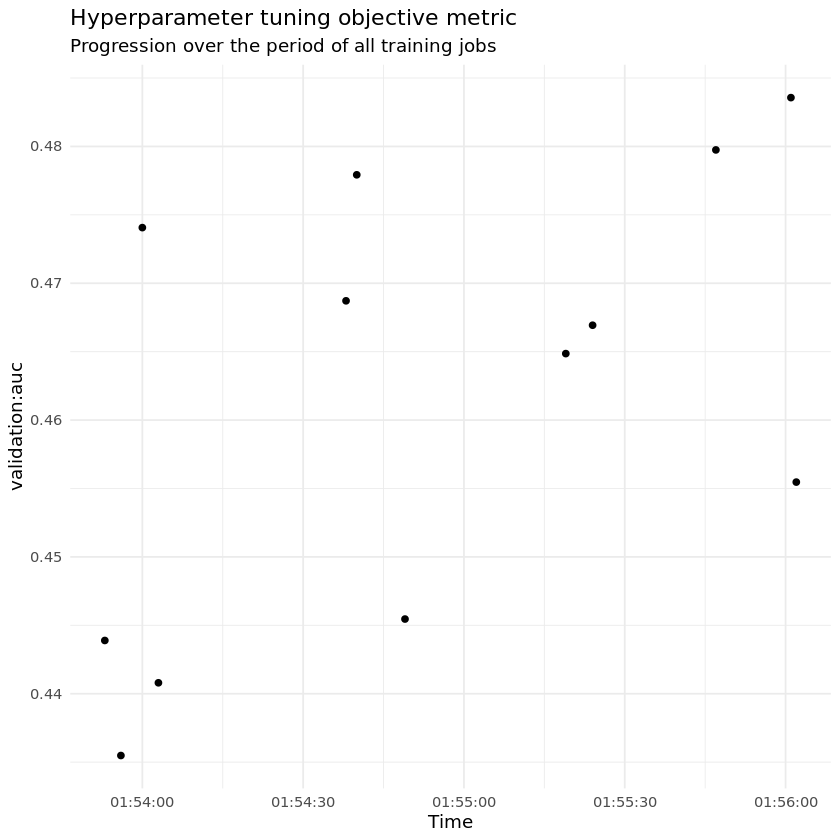

In [29]:
ggplot(tuning_results_df, aes(TrainingEndTime, FinalObjectiveValue)) +
  geom_point() +
  xlab("Time") +
  ylab(tuning_job_results$description()$TrainingJobDefinition$StaticHyperParameters$`_tuning_objective_metric`) +
  ggtitle("Hyperparameter tuning objective metric",  
          "Progression over the period of all training jobs") +
  theme_minimal()

In [30]:
best_tuned_model <- tuning_results_df %>%
  filter(FinalObjectiveValue == max(FinalObjectiveValue)) %>%
  pull(TrainingJobName)
best_tuned_model

[1] "tune-xgboost-20230316-01-51-30-010-ccba151c"

In [31]:
training_job_stats <- session$describe_training_job(job_name = best_tuned_model)

final_metrics <-  map_df(training_job_stats$FinalMetricDataList, 
                          ~tibble(metric_name = .x[["MetricName"]],
                                  value = .x[["Value"]]))
final_metrics

metric_name,value
<chr>,<dbl>
validation:auc,0.483566
train:auc,0.975392
ObjectiveMetric,0.483566


In [ ]:
predictions_path <- paste0("s3://", bucket, "/", project_name, "/", model_name, "/", 'models')

predictions_path